In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pickle
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from geopack import geopack
import pyspedas
import sys
import pandas as pd
import seaborn as sns
import xarray as xr

sys.path.append('/Users/sr2/opt/anaconda3/envs/nipr_env/')
from esn_dts_openloop import ESN, Tikhonov

Load IGRF coefficients ...


In [2]:
#REPPU otuputs
path = r'/Users/sr2/OneDrive - University College London/PhD/Experiences/Postdocs/JSPS/Research/Data/pbig5min.dat'

#read the REPPU data
with open (path) as f:
    rectype = np.dtype(np.float32)
    reppu_data = np.fromfile(f, rectype) #size = 109,900,800

In [3]:
#Read MHD dates and expand-out the date ranges
mhd_data = pd.read_csv('mhd_dates.csv')
expanded_dt = pd.concat([pd.Series(pd.date_range(start, end)) 
        for start, end in zip(mhd_data['start'], mhd_data['end'])])

In [4]:
# Reshape the array to have dimensions (days, time (5-min intervals), lat, lon)
#288 will become 1440 at 1-min resolution in SMRAI v3.0
data_reshaped = reppu_data.reshape(len(expanded_dt), 288, 30, 80) 

# Define coordinates
time = np.arange(288)
lat = np.linspace(53.1, 89.7, 30) #30 intervals between 53.1° to 89.7°
lon = np.linspace(1.6, 357.6, 80) #80 intervals between 1.6° to 357.6°

# Create 'dt' variable combining dates and five-minute intervals
dt = []
for day in expanded_dt:
    for t in time:
        dt.append(day + pd.Timedelta(minutes=t*5))
dt = np.array(dt) #convert from list to numpy array

# Create xarray Dataset
ds = xr.Dataset({'potential': (['dt', 'lat', 'lon'], data_reshaped.reshape(-1, 30, 80))},
                coords={'dt': dt, 'lat': lat, 'lon': lon})

# Add potential and units
ds['potential'].attrs['units'] = 'kV'
ds['potential'] = ds['potential'] * 1e-3 # Convert to kV
ds

<xarray.Dataset> Size: 440MB
Dimensions:    (dt: 45792, lat: 30, lon: 80)
Coordinates:
  * dt         (dt) datetime64[ns] 366kB 2021-05-10 ... 2022-07-31T23:55:00
  * lat        (lat) float64 240B 53.1 54.36 55.62 56.89 ... 87.18 88.44 89.7
  * lon        (lon) float64 640B 1.6 6.106 10.61 15.12 ... 348.6 353.1 357.6
Data variables:
    potential  (dt, lat, lon) float32 440MB 0.6909 0.507 ... -22.67 -22.71

In [5]:
#open the omni data and merge it with the REPPU data
omni_mhd_path = r'/Users/sr2/OneDrive - University College London/PhD/Experiences/Postdocs/JSPS/Research/Analysis/Apr-24/data/omni/'
omni_df = pd.read_csv(omni_mhd_path+'omni_mhd_1min.csv')
omni_df.set_index('dt', inplace=True) #set the datetime as the index
omni_df = omni_df.dropna()

omni_ds = xr.Dataset(omni_df)
omni_ds['dt'] = pd.to_datetime(omni_ds['dt']) #convert the index to datetime

#merge OMNI with REPPU data
reppu_omni_ds = ds.merge(omni_ds, join='inner')
reppu_omni_ds.sortby('dt')
reppu_omni_ds

<xarray.Dataset> Size: 409MB
Dimensions:         (dt: 42158, lat: 30, lon: 80)
Coordinates:
  * dt              (dt) datetime64[ns] 337kB 2021-05-10 ... 2022-07-31T23:55:00
  * lat             (lat) float64 240B 53.1 54.36 55.62 ... 87.18 88.44 89.7
  * lon             (lon) float64 640B 1.6 6.106 10.61 ... 348.6 353.1 357.6
Data variables:
    potential       (dt, lat, lon) float32 405MB 0.6909 0.507 ... -22.67 -22.71
    BY_GSE          (dt) float64 337kB 4.72 4.35 4.61 4.65 ... -8.77 -9.31 -8.22
    BZ_GSE          (dt) float64 337kB 6.24 6.55 6.56 6.89 ... -0.74 -4.03 -4.71
    flow_speed      (dt) float64 337kB 344.0 344.8 345.5 ... 454.7 465.0 478.1
    proton_density  (dt) float64 337kB 12.11 11.44 12.65 ... 8.03 7.08 6.84
    T               (dt) float64 337kB 2.457e+04 1.984e+04 ... 1.949e+05
    Pressure        (dt) float64 337kB 2.87 2.72 3.02 3.0 ... 3.33 3.06 3.13
    E               (dt) float64 337kB -2.63 -2.68 -2.73 ... -0.07 1.33 1.91
    Mach_num        (dt) float64 337kB 7.3 7.0 7.3 7.1 6.8 ... 6.0 6.6 5.9 6.5
    BSN_x           (dt) float64 337kB 12.82 12.85 12.72 ... 12.43 12.03 11.72
    doy             (dt) float64 337kB 130.0 130.0 130.0 ... 212.0 212.0 212.0
    tilt_angle      (dt) float64 337kB 0.253 0.2497 0.2465 ... 0.2744 0.271

In [6]:
# Define the slice ranges for train and test data
train_slice = slice(0, 36576)  #36576 / 24 / 12 = 127 days = 80% of the data
test_slice = slice(36576, None)  # 9216 / 24 / 12 = 32 days = 20% of the data

# Create ds_train and ds_test datasets
ds_train = reppu_omni_ds.isel(dt=train_slice)
ds_test = reppu_omni_ds.isel(dt=test_slice)

In [7]:
def nan_count(ds, var):
    #count number of NaNs in a data variable
    con_data = ds[var].values
    nan_count = np.count_nonzero(np.isnan(con_data))
    nan_ratio = nan_count / con_data.size
    not_nan = con_data.size - nan_count
    return not_nan, np.round(nan_ratio, 2)

#nan_count(ds_test, 'doy')

In [8]:
#training
X_train = ds_train.drop_vars('potential').to_array().values.T
y_train = ds_train['potential'].values
y_train = y_train.reshape(-1, 30*80)

#testing
X_test = ds_test.drop_vars('potential').to_array().values.T
y_test = ds_test['potential'].values
y_test = y_test.reshape(-1, 30*80)

In [9]:
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]
reservoir_size = 250

model = ESN(N_u = input_dim, N_y = output_dim, N_x=reservoir_size, density=0.1, input_scale=0.1, rho=0.99)
optimizer = Tikhonov(N_u = input_dim, N_x = reservoir_size, N_y = output_dim, beta=1e-3)
model.train(X_train, y_train, optimizer)

In [ ]:
y_pred = model.predict(X_test)
y_pred = y_pred.reshape(-1, 30, 80)
y_pred.shape

(5582, 30, 80)

In [ ]:
# Create xarray Dataset
ds_pred = xr.Dataset({'potential': (['dt', 'lat', 'lon'], y_pred)},
                coords={'dt': ds_test['dt'], 'lat': ds_test['lat'], 'lon': ds_test['lon']})

# Add potential and units
ds_pred['potential'].attrs['units'] = 'kV'
ds_pred['potential'] = ds_pred['potential'] # Convert to kV
ds_pred

#add other variables to the prediction dataset
ds_pred = ds_pred.merge(ds_test.drop_vars('potential'))
ds_pred

<xarray.Dataset> Size: 108MB
Dimensions:         (dt: 5582, lat: 30, lon: 80)
Coordinates:
  * dt              (dt) datetime64[ns] 45kB 2022-07-11T15:05:00 ... 2022-07-...
  * lat             (lat) float64 240B 53.1 54.36 55.62 ... 87.18 88.44 89.7
  * lon             (lon) float64 640B 1.6 6.106 10.61 ... 348.6 353.1 357.6
Data variables:
    potential       (dt, lat, lon) float64 107MB 3.898 3.436 ... -19.58 -19.62
    BY_GSE          (dt) float64 45kB 7.96 8.2 8.13 8.94 ... -8.77 -9.31 -8.22
    BZ_GSE          (dt) float64 45kB -3.35 -2.99 -2.57 ... -0.74 -4.03 -4.71
    flow_speed      (dt) float64 45kB 340.7 341.9 337.1 ... 454.7 465.0 478.1
    proton_density  (dt) float64 45kB 9.32 9.77 10.02 9.5 ... 8.03 7.08 6.84
    T               (dt) float64 45kB 5.825e+04 5.987e+04 ... 1.949e+05
    Pressure        (dt) float64 45kB 2.16 2.29 2.28 2.15 ... 3.33 3.06 3.13
    E               (dt) float64 45kB 1.71 1.62 1.44 1.41 ... -0.07 1.33 1.91
    Mach_num        (dt) float64 45kB 5.0 5.0 5.0 4.8 4.9 ... 6.0 6.6 5.9 6.5
    BSN_x           (dt) float64 45kB 12.98 12.93 13.07 ... 12.43 12.03 11.72
    doy             (dt) float64 45kB 192.0 192.0 192.0 ... 212.0 212.0 212.0
    tilt_angle      (dt) float64 45kB 0.5268 0.5285 0.5301 ... 0.2744 0.271

Text(0, 0.5, 'Potential ($\\phi$) [kV]')

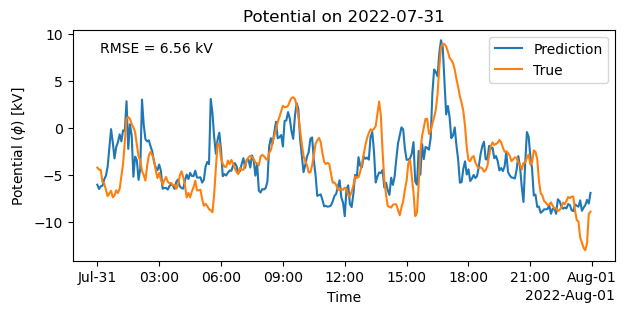

In [ ]:
#plot potential on 2022-07-11, integrtaed over lat and lon


#2022-07-31 is okay
date = '2022-07-31'
fig, ax = plt.subplots(figsize=(7, 3))
ds_pred['potential'].sel(dt=date).mean(['lat', 'lon']).plot(label='Prediction')
ds_test['potential'].sel(dt=date).mean(['lat', 'lon']).plot(label='True')

rmse = np.sqrt(np.mean((ds_pred['potential'].sel(dt=date).values - ds_test['potential'].sel(dt=date).values)**2))
plt.annotate(f'RMSE = {rmse:.2f} kV', xy=(0.05, 0.9), xycoords='axes fraction')

plt.legend()
plt.title(f'Potential on {date}')
plt.xlabel('Time')
phi = r'$\phi$'
plt.ylabel(f'Potential ({phi}) [kV]')


In [ ]:
#print unique dates from ds_pred dt
dates = ds_pred['dt'].dt.strftime('%Y-%m-%d').values
unique_dates = np.unique(dates)
unique_dates

array(['2022-07-11', '2022-07-12', '2022-07-13', '2022-07-14',
       '2022-07-15', '2022-07-16', '2022-07-17', '2022-07-18',
       '2022-07-19', '2022-07-20', '2022-07-21', '2022-07-22',
       '2022-07-23', '2022-07-24', '2022-07-25', '2022-07-26',
       '2022-07-27', '2022-07-28', '2022-07-29', '2022-07-30',
       '2022-07-31'], dtype=object)

In [ ]:
date = '2022-07-31'

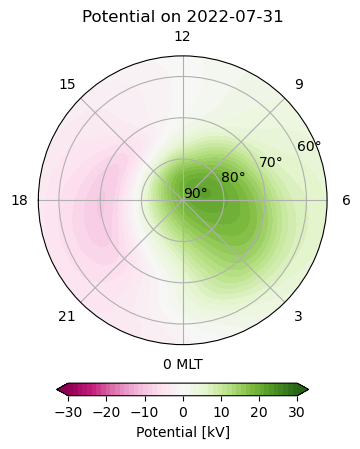

In [ ]:
pot_pred = ds_pred['potential'].sel(dt=date).values
pot_pred = pot_pred[1]

#plot
theta = np.linspace(0, 360, 80) 
theta = theta - 90
theta = theta / 360 * np.pi * 2

r = np.linspace(53.1, 89.7, 30)
r = 90 - r
theta, r = np.meshgrid(theta, r)

upper = 30
lower = -30
intervals = 50

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(5, 5))
c = ax.contourf(theta, r, -pot_pred, levels=np.linspace(lower,upper, intervals), 
                cmap='PiYG', extend='both')

plt.colorbar(c, ax=ax, label='Potential [kV]', shrink=0.65, pad=0.1, 
        ticks=np.arange(lower,upper+1,10), orientation='horizontal')

ax.set_ylim([0, 35])
ax.set_yticks([0, 10, 20, 30])
ax.set_yticklabels(["90°", "80°", "70°", "60°"])
ax.set_xlim([-np.pi, np.pi])
ax.set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
ax.set_xticklabels(["21", "0 MLT", "3", "6", "9", "12", "15", "18"])

plt.title(f'Potential on {date}')
plt.show()


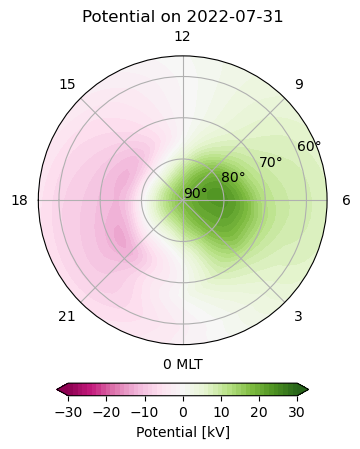

In [ ]:
pot_true = ds_test['potential'].sel(dt=date).values
pot_true = pot_true[1]

theta = np.linspace(0, 360, 80) 
theta = theta - 90
theta = theta / 360 * np.pi * 2

r = np.linspace(53.1, 89.7, 30)
r = 90 - r
theta, r = np.meshgrid(theta, r)

upper = 30
lower = -30
intervals = 50

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(5, 5))
c = ax.contourf(theta, r, -pot_true, levels=np.linspace(lower,upper, intervals), cmap='PiYG', extend='both')

plt.colorbar(c, ax=ax, label='Potential [kV]', shrink=0.65, pad=0.1, 
        ticks=np.arange(lower,upper+1,10), orientation='horizontal')

ax.set_ylim([0, 35])
ax.set_yticks([0, 10, 20, 30])
ax.set_yticklabels(["90°", "80°", "70°", "60°"])
ax.set_xlim([-np.pi, np.pi])
ax.set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
ax.set_xticklabels(["21", "0 MLT", "3", "6", "9", "12", "15", "18"])

plt.title(f'Potential on {date}')
plt.show()


In [ ]:
ds_test['potential'].sel(dt=date).values[281]

array([[ 1.5675708e+00,  9.0331256e-01,  2.3003228e-01, ...,
         3.4652412e+00,  2.8536394e+00,  2.2191949e+00],
       [ 1.5429267e+00,  8.2812750e-01,  1.1041348e-01, ...,
         3.6081755e+00,  2.9383197e+00,  2.2478912e+00],
       [ 1.5192542e+00,  7.4609339e-01, -1.2868605e-02, ...,
         3.7738082e+00,  3.0361531e+00,  2.2829888e+00],
       ...,
       [-3.2905952e+01, -3.3294495e+01, -3.3703651e+01, ...,
        -3.1813044e+01, -3.2167603e+01, -3.2529194e+01],
       [-3.4245937e+01, -3.4474899e+01, -3.4711399e+01, ...,
        -3.3610214e+01, -3.3811417e+01, -3.4024014e+01],
       [-3.5307030e+01, -3.5353073e+01, -3.5400108e+01, ...,
        -3.5177662e+01, -3.5219055e+01, -3.5262272e+01]], dtype=float32)

In [ ]:
times = ds_test['dt'].values
times

array(['2022-07-11T15:05:00.000000000', '2022-07-11T15:10:00.000000000',
       '2022-07-11T15:15:00.000000000', ...,
       '2022-07-31T23:45:00.000000000', '2022-07-31T23:50:00.000000000',
       '2022-07-31T23:55:00.000000000'], dtype='datetime64[ns]')

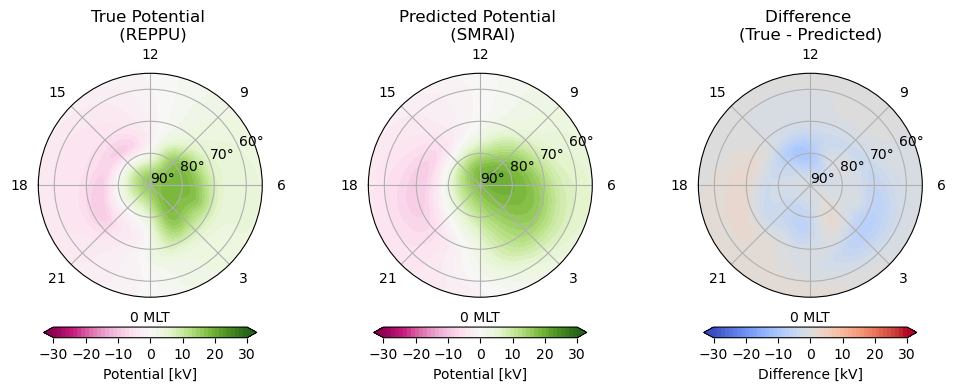

In [ ]:
# Define the date
date = "2022-07-31"

# Extract true and predicted values
pot_true = ds_test['potential'].sel(dt=date).values[0]
pot_pred = ds_pred['potential'].sel(dt=date).values[0]

# Calculate the difference
diff = pot_true - pot_pred

# Set up the plot
fig, axs = plt.subplots(1, 3, subplot_kw={'projection': 'polar'}, figsize=(14, 4))

# Define common parameters
theta = np.linspace(0, 360, 80) - 90
theta_rad = theta / 360 * 2 * np.pi
r = 90 - np.linspace(53.1, 89.7, 30)
shrink = .3

# Plot true values
c_true = axs[0].contourf(theta_rad, r, -pot_true, levels=np.linspace(-30, 30, 50), cmap='PiYG', extend='both')
axs[0].set_ylim([0, 35])
axs[0].set_yticks([0, 10, 20, 30])
axs[0].set_yticklabels(["90°", "80°", "70°", "60°"])
axs[0].set_xlim([-np.pi, np.pi])
axs[0].set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
axs[0].set_xticklabels(["21", "0 MLT", "3", "6", "9", "12", "15", "18"])
axs[0].set_title(f'True Potential \n (REPPU)')
plt.colorbar(c_true, ax=axs[0], label='Potential [kV]', shrink=shrink, pad=0.1, ticks=np.arange(-30, 31, 10), orientation='horizontal')

# Plot predicted values
c_pred = axs[1].contourf(theta_rad, r, -pot_pred, levels=np.linspace(-30, 30, 50), cmap='PiYG', extend='both')
axs[1].set_ylim([0, 35])
axs[1].set_yticks([0, 10, 20, 30])
axs[1].set_yticklabels(["90°", "80°", "70°", "60°"])
axs[1].set_xlim([-np.pi, np.pi])
axs[1].set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
axs[1].set_xticklabels(["21", "0 MLT", "3", "6", "9", "12", "15", "18"])
axs[1].set_title(f'Predicted Potential \n (SMRAI)')
plt.colorbar(c_pred, ax=axs[1], label='Potential [kV]', shrink=shrink, pad=0.1, ticks=np.arange(-30, 31, 10), orientation='horizontal')

# Plot difference
c_diff = axs[2].contourf(theta_rad, r, -diff, levels=np.linspace(-30, 30, 50), cmap='coolwarm', extend='both')
axs[2].set_ylim([0, 35])
axs[2].set_yticks([0, 10, 20, 30])
axs[2].set_yticklabels(["90°", "80°", "70°", "60°"])
axs[2].set_xlim([-np.pi, np.pi])
axs[2].set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
axs[2].set_xticklabels(["21", "0 MLT", "3", "6", "9", "12", "15", "18"])
axs[2].set_title('Difference \n(True - Predicted)')
plt.colorbar(c_diff, ax=axs[2], label='Difference [kV]', shrink=shrink, pad=0.1, ticks=np.arange(-30, 31, 10), orientation='horizontal')

plt.subplots_adjust(wspace=-0.7)  # Adjust horizontal space between subplots

plt.tight_layout()
plt.show()


In [ ]:

# Select the date
date = "2022-07-31"

# Extract times from dt dimension info
times = ds_test.sel(dt=date)['dt'].values

# Define common parameters
theta = np.linspace(0, 360, 80) - 90
theta_rad = theta / 360 * 2 * np.pi
r = 90 - np.linspace(53.1, 89.7, 30)
shrink = .28
pad = 0.13
phi = r"$\mathrm{\phi}$"

# Loop through each time step
for i, time in enumerate(times):
    # Extract true and predicted values for the current time
    pot_true = ds_test['potential'].sel(dt=date).values[i]
    pot_pred = ds_pred['potential'].sel(dt=date).values[i]

    # Calculate the difference
    diff = pot_true - pot_pred

    # Set up the plot
    fig, axs = plt.subplots(1, 3, subplot_kw={'projection': 'polar'}, figsize=(14, 4))

    # Plot true values
    c_true = axs[0].contourf(theta_rad, r, -pot_true, levels=np.linspace(-30, 30, 50), cmap='PiYG', extend='both')
    axs[0].set_ylim([0, 30])
    axs[0].set_yticks([0, 10, 20, 30])
    axs[0].set_yticklabels(["90°", "80°", "70°", "60°"])
    axs[0].set_xlim([-np.pi, np.pi])
    axs[0].set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
    axs[0].set_xticklabels(["21", "0 MLT", "3", "6", "9", "12", "15", "18"])
    axs[0].set_title(f'True Potential \n (REPPU)')
    plt.colorbar(c_true, ax=axs[0], label=f'Potential ({phi}) [kV]', shrink=shrink, pad=pad, ticks=np.arange(-30, 31, 10), orientation='horizontal')

    # Plot predicted values
    c_pred = axs[1].contourf(theta_rad, r, -pot_pred, levels=np.linspace(-30, 30, 50), cmap='PiYG', extend='both')
    axs[1].set_ylim([0, 30])
    axs[1].set_yticks([0, 10, 20, 30])
    axs[1].set_yticklabels(["90°", "80°", "70°", "60°"])
    axs[1].set_xlim([-np.pi, np.pi])
    axs[1].set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
    axs[1].set_xticklabels(["21", "0 MLT", "3", "6", "9", "12", "15", "18"])
    axs[1].set_title('Predicted Potential \n (SMRAI)')
    plt.colorbar(c_pred, ax=axs[1], label=f'Potential ({phi}) [kV]', shrink=shrink, pad=pad, ticks=np.arange(-30, 31, 10), orientation='horizontal')

    # Plot difference
    c_diff = axs[2].contourf(theta_rad, r, -diff, levels=np.linspace(-30, 30, 50), cmap='coolwarm', extend='both')
    axs[2].set_ylim([0, 30])
    axs[2].set_yticks([0, 10, 20, 30])
    axs[2].set_yticklabels(["90°", "80°", "70°", "60°"])
    axs[2].set_xlim([-np.pi, np.pi])
    axs[2].set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
    axs[2].set_xticklabels(["21", "0 MLT", "3", "6", "9", "12", "15", "18"])
    axs[2].set_title(f'Difference \n(True - Predicted)')
    plt.colorbar(c_diff, ax=axs[2], label=f'Difference ({phi}) [kV]', shrink=shrink, pad=pad, ticks=np.arange(-30, 31, 10), orientation='horizontal')

    plt.subplots_adjust(wspace=-0.8)  # Adjust horizontal space between subplots

    plt.tight_layout()

    dt = pd.to_datetime(time)
    str_time = dt.strftime('%Y-%m-%d %H:%M')

    plt.annotate(f'{str_time}', xy=(-1.24, -0.6), xycoords='axes fraction', fontsize=12)

    # Save the figure with the timestamp in the title
    #export_path = r'/Users/sr2/OneDrive - University College London/PhD/Experiences/Postdocs/Research/JSPS/Analysis/Apr-24/plots/SMRAI3/potential/2022-07-31/'
    plt.savefig(f'/Users/sr2/OneDrive - University College London/PhD/Experiences/Postdocs/JSPS/Research/Analysis/Apr-24/plots/SMRAI3/potential/2022-07-31/potential_plot_{str_time}.png', dpi=300, bbox_inches='tight')

    # Close the figure to free up memory
    plt.close(fig)

    #break